We can start by importing the needed libraries, and opening the dataset, which was sorted beforehand in Excel.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 
MRT_data = pd.read_csv('C:/Users/tohle/Downloads/transport_node_train_202501_sorted.csv') #change the path to whatever your file path is
print(MRT_data.head(25))
print(MRT_data.info())

   YEAR_MONTH          DAY_TYPE  TIME_PER_HOUR PT_TYPE PT_CODE  \
0     2025-01           WEEKDAY              0   TRAIN    BP10   
1     2025-01           WEEKDAY              5   TRAIN    BP10   
2     2025-01           WEEKDAY              6   TRAIN    BP10   
3     2025-01           WEEKDAY              7   TRAIN    BP10   
4     2025-01           WEEKDAY              8   TRAIN    BP10   
5     2025-01           WEEKDAY              9   TRAIN    BP10   
6     2025-01           WEEKDAY             10   TRAIN    BP10   
7     2025-01           WEEKDAY             11   TRAIN    BP10   
8     2025-01           WEEKDAY             12   TRAIN    BP10   
9     2025-01           WEEKDAY             13   TRAIN    BP10   
10    2025-01           WEEKDAY             14   TRAIN    BP10   
11    2025-01           WEEKDAY             15   TRAIN    BP10   
12    2025-01           WEEKDAY             16   TRAIN    BP10   
13    2025-01           WEEKDAY             17   TRAIN    BP10   
14    2025

Let's begin with some EDA. First, let's plot the metric we want to predict, TOTAL_TAP_IN_VOLUME, and see what it looks like.

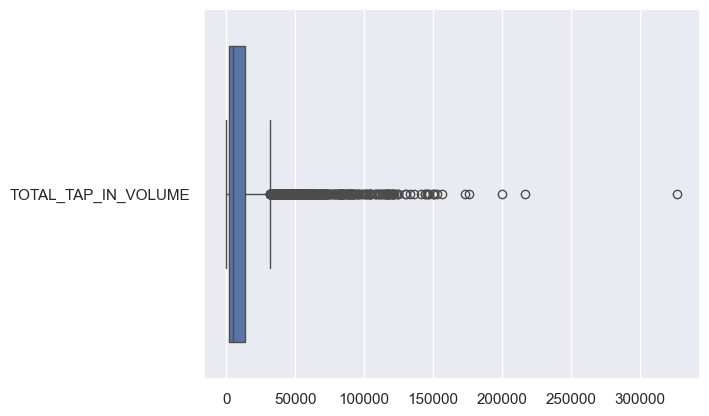

<Axes: ylabel='Count'>

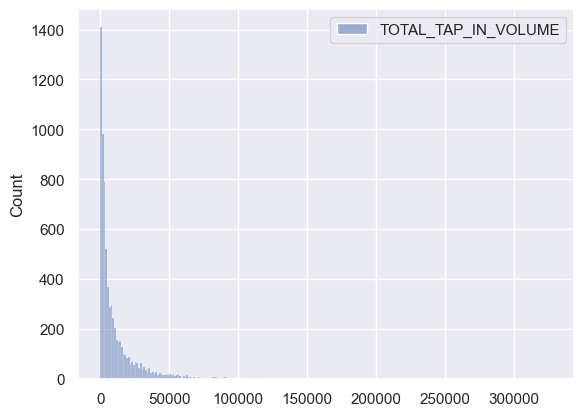

In [4]:
tap_in = pd.DataFrame(MRT_data["TOTAL_TAP_IN_VOLUME"]) 
sb.boxplot(data=tap_in, orient="h")
plt.show()
sb.histplot(data=tap_in)

Next, let's dig into the variables and see how many of each we have.

In [ ]:
print(MRT_data.describe(include="object"))
MRT_time = MRT_data["TIME_PER_HOUR"]
MRT_time.describe()
MRT_data[["TOTAL_TAP_IN_VOLUME", "TOTAL_TAP_OUT_VOLUME"]].describe() #numericals

       YEAR_MONTH DAY_TYPE PT_TYPE  PT_CODE
count        7220     7220    7220     7220
unique          1        2       1      181
top       2025-01  WEEKDAY   TRAIN  EW8/CC9
freq         7220     3611    7220       40


,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
count,7220.000000,7220.000000
mean,11756.268283,11717.421053
std,18759.131248,18797.059748
min,0.000000,0.000000
25%,1708.750000,1812.750000
50%,4701.500000,4780.500000
75%,13769.500000,13370.250000
max,326914.000000,318949.000000


We see that YEAR_MONTH is all the same values of 2025-01, indicating all the data is from January 2025. PT_TYPE is also all TRAIN, meanig there are no values from other modes of transport like the bus. DAY_TYPE has 2 types, WEEKDAY, and WEEKEND/HOLIDAY. There are 181 unique stations as indicated by PT_CODE. 
While not printed here, from an earlier line of code, we can see that TIME_PER_HOUR has the ranges of 0, and then 5 to 23. From the information provided in the API documentation, TIME_PER_HOUR indicates which hour this was recorded (so a TIME_PER_HOUR OF 12 indicates that the data was recorded from 1200hrs to 1259hrs).


Next, to simplify, we can eliminate some of the unneccessary columns, like PT_TYPE, and YEAR_MONTH, as they are all the same values. We also will drop TOTAL_TAP_OUT_VOLUME, as we are using TOTAL_TAP_IN_VOLUME as our predictor. This is because tap in volumes indicate riders entering a station, which means it better shows how busy a station is at some given time.

In [ ]:
MRT_data = MRT_data.drop(columns=["PT_TYPE","YEAR_MONTH", "TOTAL_TAP_OUT_VOLUME"])
print(MRT_data.head())

  DAY_TYPE  TIME_PER_HOUR PT_CODE  TOTAL_TAP_IN_VOLUME
0  WEEKDAY              0    BP10                    0
1  WEEKDAY              5    BP10                 3297
2  WEEKDAY              6    BP10                 9312
3  WEEKDAY              7    BP10                12984
4  WEEKDAY              8    BP10                 7901


For PT_CODE, let's break up the stations into class types, as the data has 3 types of stations. Stations which are only the MRT, stations which are only the LRT, and stations which are interchanges between MRT and the LRT.
Checking the meaning of the codes and the data, we find out that:
Codes starting with BP/PW/PE/SE/SW refer to LRT lines (Bukit Panjang LRT, Punggol LRT, and Sengkang LRT respectively. PTC and STC are also used to refer to LRT lines, but as the stations where they are used are interchanges, they will be ignored in our code.)
All the other codes (NS/EW/NE/CC/DT/TE) refer to the MRT lines
If the PT_CODE column for a row contains a slash, it indicates it has 2 or more different codes, and is an interchange.

In [ ]:
#print(MRT_data)
pt_code = MRT_data["PT_CODE"] #we want to check only this column
#print(pt_code.head())
station_type = [] #use a list to build a new column
for row in pt_code:
    if "/" in row: #interchange station
        station_type.append("INTERCHANGE")
    elif "BP" in row or "PW" in row or "PE" in row or "PW" in row or "SE" in row or "SW" in row: #LRT
        station_type.append("LRT") 
    else: #MRT
        station_type.append("MRT") 
#print(MRT_data.head())
MRT_data.insert(3, "STATION_TYPE", station_type)
print(MRT_data.head())

  DAY_TYPE  TIME_PER_HOUR PT_CODE STATION_TYPE  TOTAL_TAP_IN_VOLUME
0  WEEKDAY              0    BP10          LRT                    0
1  WEEKDAY              5    BP10          LRT                 3297
2  WEEKDAY              6    BP10          LRT                 9312
3  WEEKDAY              7    BP10          LRT                12984
4  WEEKDAY              8    BP10          LRT                 7901


To better sort the categorical variables DAY_TYPE and STATION_TYPE, we can use OneHotEncoding and then combine the resultant columns into our new dataframe

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder() #ohe our day time and station type
ohe_cat = pd.DataFrame(MRT_data["DAY_TYPE"])
station_ohe = pd.DataFrame(MRT_data["STATION_TYPE"])
#print(station_ohe.tail())
#print(ohe_cat.tail())
ohe.fit(ohe_cat)
MRTData_ohe = pd.DataFrame(ohe.transform(ohe_cat).toarray(), columns=ohe.get_feature_names_out(ohe_cat.columns))
ohe.fit(station_ohe)
ohe_df = pd.DataFrame(ohe.transform(station_ohe).toarray(), columns=ohe.get_feature_names_out(station_ohe.columns))
#print(MRTData_ohe.tail())
MRTData_vals = MRT_data[["TIME_PER_HOUR","PT_CODE","TOTAL_TAP_IN_VOLUME","TOTAL_TAP_OUT_VOLUME"]]
MRTData_withohe = pd.concat([MRTData_vals, MRTData_ohe,ohe_df], sort = False, axis = 1).reindex(index=MRTData_vals.index)
print(MRTData_withohe.head())



KeyError: "['TOTAL_TAP_OUT_VOLUME'] not in index"

Now, we need to split the data into train data and test data. We will use scikit's train_test split to get our data.

In [ ]:
from sklearn.model_selection import train_test_split
#print(MRTData_withohe.shape)
#MRTData_weekday = MRTData_withohe[MRTData_withohe["DAY_TYPE_WEEKDAY"] == 1.0]
timedf = MRTData_withohe
cleaneddf = timedf.drop(columns=["TOTAL_TAP_IN_VOLUME","TOTAL_TAP_OUT_VOLUME", "PT_CODE"])
print(cleaneddf)
tapdf = MRTData_withohe["TOTAL_TAP_IN_VOLUME"]
time_train, time_test, tap_train, tap_test = train_test_split(cleaneddf, tapdf, test_size=0.25, random_state=42)
print(time_train.head())
print(tap_train.head())


      TIME_PER_HOUR  DAY_TYPE_WEEKDAY  DAY_TYPE_WEEKENDS/HOLIDAY  \
0                 0               1.0                        0.0   
1                 5               1.0                        0.0   
2                 6               1.0                        0.0   
3                 7               1.0                        0.0   
4                 8               1.0                        0.0   
...             ...               ...                        ...   
7215             19               0.0                        1.0   
7216             20               0.0                        1.0   
7217             21               0.0                        1.0   
7218             22               0.0                        1.0   
7219             23               0.0                        1.0   

      STATION_TYPE_INTERCHANGE  STATION_TYPE_LRT  STATION_TYPE_MRT  
0                          0.0               1.0               0.0  
1                          0.0               

Before we try to predict TOTAL_TAP_IN_VOLUME, let's look at a barplot between TIME_PER_HOUR and TOTAL_TAP_IN_VOLUME.

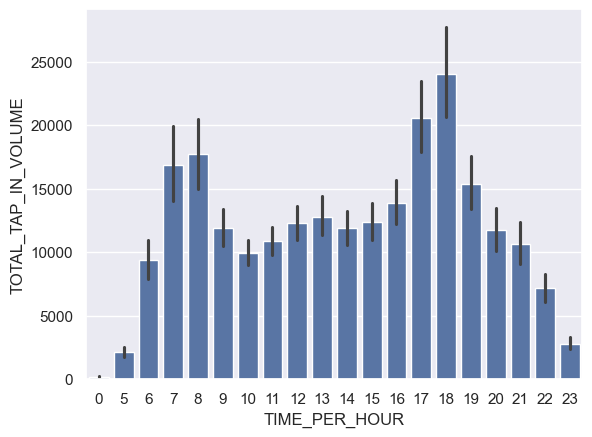

In [ ]:
jdf = pd.concat([cleaneddf,tapdf], axis=1).reindex(timedf.index)
sb.barplot(data = jdf, x = "TIME_PER_HOUR", y = "TOTAL_TAP_IN_VOLUME")
plt.show()

From the graph, we can see the data has 2 peaks, at around 6-7, and 18. So a linear regression model might not neccessarily be the best model. Hence, we will compare it to other models, like quadratic regression. We start by looking at a linear regression model first.
To improve the model, we will do multiple linear regression, where multiple predictor variables (in our case, everything but the tap in volumes) are used to try and predict the response variable.

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(time_train, tap_train)
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

tap_predict = linreg.predict(time_train)

Intercept 	: b =  10698.806771126374
Coefficients 	: a =  [   253.71197895   4902.70863638  -4902.70863638  14931.65849441
 -11534.32425358  -3397.33424082]


Let's study the mean squared error explained variance of the train set, and test set. Given we are using multiple linear regression, we cannot display the data onto a simple 2D graph, so we will have to display the effectiveness through explained variance.

In [ ]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(time_train, tap_train))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))


mse = mean_sq_err(tap_train, tap_predict)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))


tap_test_pred = linreg.predict(time_test)
print("Using test set:")
print("Explained Variance (R^2) \t:", linreg.score(time_test, tap_test))


mse = mean_sq_err(tap_test, tap_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))


Explained Variance (R^2) 	: 0.24601779175176097
Mean Squared Error (MSE) 	: 277898053.6765318
Root Mean Squared Error (RMSE) 	: 16670.274553123945
Using test set:
Explained Variance (R^2) 	: 0.26446969030104506
Mean Squared Error (MSE) 	: 221866298.23557603
Root Mean Squared Error (RMSE) 	: 14895.177012562692


So from the explained variance, we can see that the linear regression model is suboptimal, with a very low explained variance. Therefore, we need to try other models. Let's look at quadratic regression, where we try to fit the data on a quadratic curve.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
quad = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
model = LinearRegression()
quad_data = quad.fit_transform(time_train)
#print(quad_data)
quad_data = quad_data#[:,[2]]
#print(quad_data)
quad_model = model.fit(quad_data, tap_train)

print('Intercept \t: b = ', model.intercept_)
print('Coefficients \t: a = ', model.coef_)

tap_predictq = quad_model.predict(quad_data)
#print(quad_data.shape)
#print(time_train)
#print(quad_data)
#print(tap_train.shape)

Intercept 	: b =  -2856.3224809469284
Coefficients 	: a =  [ 4.20448347e-12  1.47139225e+03  2.39694940e+03 -2.39694940e+03
  9.92720932e+02 -1.78553830e+03  7.92817371e+02 -8.84265322e+01
  7.38829460e+02  7.32562787e+02  1.43044285e+03 -4.84941853e+01
  8.94435798e+01  2.39694940e+03  0.00000000e+00  6.82055788e+03
 -4.60289681e+03  1.79288325e+02 -2.39694940e+03 -5.82783695e+03
  2.81735850e+03  6.13529046e+02  9.92720932e+02  0.00000000e+00
  0.00000000e+00 -1.78553830e+03  0.00000000e+00  7.92817371e+02]


Checking the MSE and explained variance:


In [ ]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", model.score(quad_data, tap_train))

mse = mean_sq_err(tap_train, tap_predictq)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))
quad_test = quad.fit_transform(time_test)
quad_test = quad_test#[:,[2]]

tap_test_predq = model.predict(quad_test)

print("Using test set:")
print("Explained Variance (R^2) \t:", quad_model.score(quad_test, tap_test))


mse = mean_sq_err(tap_test, tap_test_predq)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))



Explained Variance (R^2) 	: 0.33060935516221934
Mean Squared Error (MSE) 	: 246719823.51134247
Root Mean Squared Error (RMSE) 	: 15707.317514819088
Using test set:
Explained Variance (R^2) 	: 0.34152218345149876
Mean Squared Error (MSE) 	: 198624086.18844748
Root Mean Squared Error (RMSE) 	: 14093.405769665736


From the numbers, while the explained variance number is higher, we can also see that Quadratic Regression is not ideal for our graph. So let's try a very different model, in the form of Random Forest Regression.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
ranForest = RandomForestRegressor(max_depth=4)
ranForest.fit(time_train, tap_train)
forestpred = ranForest.predict(time_train)



How will this model stack error wise? Let's check the MSE and explained variance.

In [ ]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", ranForest.score(time_train, tap_train))

mse = mean_sq_err(tap_train, forestpred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))


forest_test_pred = ranForest.predict(time_test)

print("Using test set:")
print("Explained Variance (R^2) \t:", ranForest.score(time_test, tap_test))


mse = mean_sq_err(tap_test, forest_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

Explained Variance (R^2) 	: 0.38175817519177213
Mean Squared Error (MSE) 	: 227867710.85063615
Root Mean Squared Error (RMSE) 	: 15095.28770347343
Using test set:
Explained Variance (R^2) 	: 0.36955544098595083
Mean Squared Error (MSE) 	: 190168098.7265588
Root Mean Squared Error (RMSE) 	: 13790.144985697532


So, while the explained variance is better than the previous models, the explained variance is still quite low and only marginally behind Quadratic Regression. Let's tweak the parameters, like n_estimators and tree-depth.

In [ ]:
ranForest = RandomForestRegressor(max_depth=20)
ranForest.fit(time_train, tap_train)
forestpred = ranForest.predict(time_train)
print("With a higher tree depth: ")
print("Explained Variance (R^2) \t:", ranForest.score(time_train, tap_train))

mse = mean_sq_err(tap_train, forestpred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))


forest_test_pred = ranForest.predict(time_test)

print("Using test set:")
print("Explained Variance (R^2) \t:", ranForest.score(time_test, tap_test))


mse = mean_sq_err(tap_test, forest_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

With a higher tree depth: 
Explained Variance (R^2) 	: 0.49096667563247076
Mean Squared Error (MSE) 	: 187616323.7682889
Root Mean Squared Error (RMSE) 	: 13697.310822504136
Using test set:
Explained Variance (R^2) 	: 0.4360511974203162
Mean Squared Error (MSE) 	: 170110234.17097655
Root Mean Squared Error (RMSE) 	: 13042.631412831406


We can see that a deeper tree yields better results, so let's try it with more n-estimators.

In [ ]:
ranForest = RandomForestRegressor(max_depth=20,n_estimators=1000,) #random_state=35)
ranForest.fit(time_train, tap_train)
forestpred = ranForest.predict(time_train)
print("With more n-estimators: ")
print("Explained Variance (R^2) \t:", ranForest.score(time_train, tap_train))

mse = mean_sq_err(tap_train, forestpred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))


forest_test_pred = ranForest.predict(time_test)

print("Using test set:")
print("Explained Variance (R^2) \t:", ranForest.score(time_test, tap_test))


mse = mean_sq_err(tap_test, forest_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

With more n-estimators: 
Explained Variance (R^2) 	: 0.49107487424015805
Mean Squared Error (MSE) 	: 187576444.60117078
Root Mean Squared Error (RMSE) 	: 13695.855015338428
Using test set:
Explained Variance (R^2) 	: 0.43632303153806606
Mean Squared Error (MSE) 	: 170028237.78191683
Root Mean Squared Error (RMSE) 	: 13039.487634946276


We see a little improvement, but it's still rather marginal. However, this could be down to the wide variety of tap in volumes each station has, with some stations seeing high tap in volumes at certain times, while others see low volumes at the same time. Now, let's convert the model into useful output, by asking it to predict ridership based on time, assuming it is a weekday, and is an interchange.

[0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[   814.1303262    4074.94148522  22299.30422273  49288.23082229
  53678.40806174  32534.48346098  23161.856808    27103.31954403
  36924.45840372  41484.22681843  36355.1010674   37830.99313133
  46820.16659393  78675.57444084 107227.86332636  64217.59694097
  52952.6137038   39594.65749493  33861.91866667  11872.53231653]


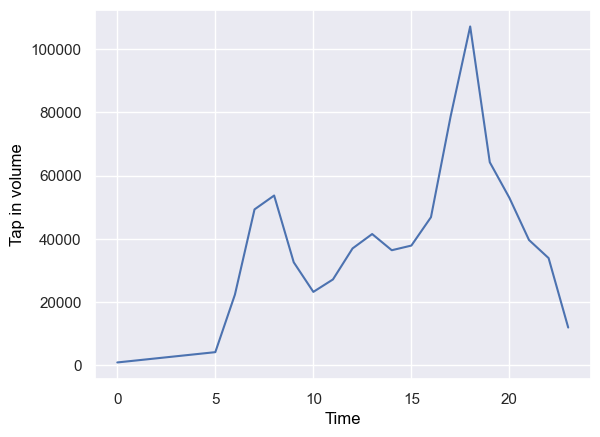

In [ ]:
time_list = [0]
for time in range(5,24):
    time_list.append(time)
print(time_list)
zero_list = []
while len(zero_list) != len(time_list):
    zero_list.append(0.0)
print(zero_list)
one_list = []
while len(one_list) != len(time_list):
    one_list.append(1.0)
print(one_list)
interchange_weekday = pd.DataFrame({"TIME_PER_HOUR": time_list, "DAY_TYPE_WEEKDAY":one_list,"DAY_TYPE_WEEKENDS/HOLIDAY":zero_list,"STATION_TYPE_INTERCHANGE":one_list,"STATION_TYPE_LRT":zero_list,"STATION_TYPE_MRT":zero_list})
interchange_predict = ranForest.predict(interchange_weekday)
print(interchange_predict)
time_array = np.array(time_list)
#plt.scatter(x=time_array, y = interchange_predict)
plt.plot(time_array,interchange_predict, label="Time")
plt.xlabel('Time', color = 'black', fontsize='12', horizontalalignment='center')
plt.ylabel('Tap in volume', color = 'black', fontsize='12', horizontalalignment='center')
plt.show()


With the above time series, we can now plot for any combination we wish, just by tweaking the prediction parameters. In fact, let's try the station being an LRT-only, and it being a weekend or holiday.

[  35.07927322  397.3994302   816.19353586 1358.90115688 1925.33091573
 2179.74881422 2405.225973   2542.67953752 2369.13183021 2190.37564655
 1905.71594655 1868.61957062 1861.66586261 1873.27192307 1962.88894276
 1311.67606455  919.8114656   774.15824508  353.54008522  129.86216818]


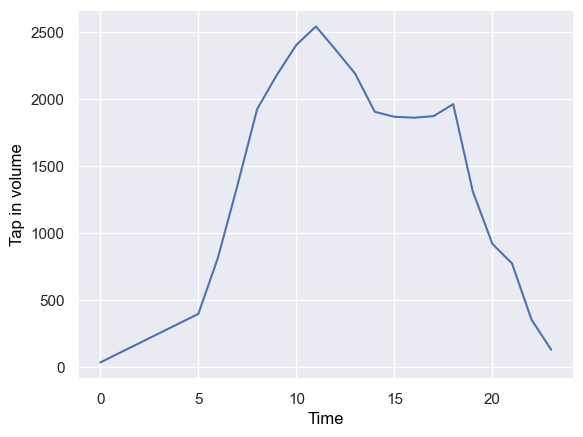

In [ ]:
LRT_weekend = pd.DataFrame({"TIME_PER_HOUR": time_list, "DAY_TYPE_WEEKDAY":zero_list,"DAY_TYPE_WEEKENDS/HOLIDAY":one_list,"STATION_TYPE_INTERCHANGE":zero_list,"STATION_TYPE_LRT":one_list,"STATION_TYPE_MRT":zero_list})
LRT_predict = ranForest.predict(LRT_weekend)
print(LRT_predict)
time_array = np.array(time_list)
#plt.scatter(x=time_array, y = interchange_predict)
plt.plot(time_array,LRT_predict, label="Time")
plt.xlabel('Time', color = 'black', fontsize='12', horizontalalignment='center')
plt.ylabel('Tap in volume', color = 'black', fontsize='12', horizontalalignment='center')
plt.show()